# An Introduction to Quantile Regression
__Date__: Fall 2022 <br>
__Author__: Alex Parker

This notebook borrows heavily from the __[Medium blog post](https://towardsdatascience.com/mean-vs-median-causal-effect-37057a6c54c9)__ by Metteo Courthoud 

#### Quantile Regression Pros:
1. Can be more informative than OLS by showing impact on the entire distribution
2. Useful for highly skewed data that may have a large proportion of 0 values
3. Can be used to show effects at different quantiles
4. More robust to outliers than OLS


#### Quantile Regression Cons:
1. median analysis does not translate well to estimated a total business impact number
2. Assumes rank invariance: the ranks of the observations do not change as a result of an intervention

#### Interpretation
Under the asusmption of rank invariance the interpretation for a QR coefficient is the estimated effect of a single observation at the appropriate qunatile. Simply put, this means that if a QR is run on the 50th percentile of customers, then the coefficients represent the estimated effects of the covariates on the median customer.



In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
import plotly.graph_objects as go
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
from my_functions import *

sns.set_theme(context = 'notebook', style = 'whitegrid')

In [2]:
ren = plotly_renderer('svg')

You've chosen static images for plotly data visualizations, these should display in github


### Data Generation: Randomized Experiment with some demographic information

In [3]:
n = 10000

# personal characteristics
age = np.random.randint(18, 70, n)
gender = np.random.choice(['male', 'female','other'], p=[0.51, 0.41,.08], size= n)
income = np.random.lognormal(4 + np.log(age), 0.1, n)

# treatment status
treatment = np.random.choice(['control','treatment'],p =[.5,.5], size = n)

# Dependant variable
spend = 50*(gender=='female') + 25*(gender == 'other') + (income/10)*np.random.normal(loc = 1, scale = .1, size = n) + (treatment == 'treatment')*np.sqrt(income)
spend = np.maximum(np.round(spend, 2) - 250, 0)

# Generate the dataframe
df = pd.DataFrame({'spend':spend,'treatment': treatment, 'age': age, 'gender': gender,'income':income})
df = df.assign(
    treatment = df.treatment.astype('category'),
    gender = df.gender.astype('category'))

df.head()

,spend,treatment,age,gender,income
0,247.07,treatment,64,other,3767.611605
1,40.07,control,49,female,2778.609263
2,0.00,control,19,female,1071.596118
3,46.72,treatment,39,female,1897.192721
4,7.96,treatment,49,male,2545.434478


#### The dependent variable is highly skewed with a high degree of 0 values

In [ ]:
sns.displot(df, x = 'spend', stat = 'density')

In [6]:
df.describe(percentiles = [.1,.25,.5,.75,.9])

,spend,age,income
count,10000.000000,10000.0000,10000.000000
mean,59.899616,43.4894,2384.077954
std,72.241163,14.9143,855.767985
min,0.000000,18.0000,759.512171
10%,0.000000,23.0000,1239.139868
25%,0.000000,31.0000,1664.944606
50%,29.225000,43.0000,2367.537694
75%,105.695000,56.0000,3058.189615
90%,168.821000,64.0000,3552.196218
max,397.790000,69.0000,5184.338912


Text(0.5, 1.0, 'Income and Age')

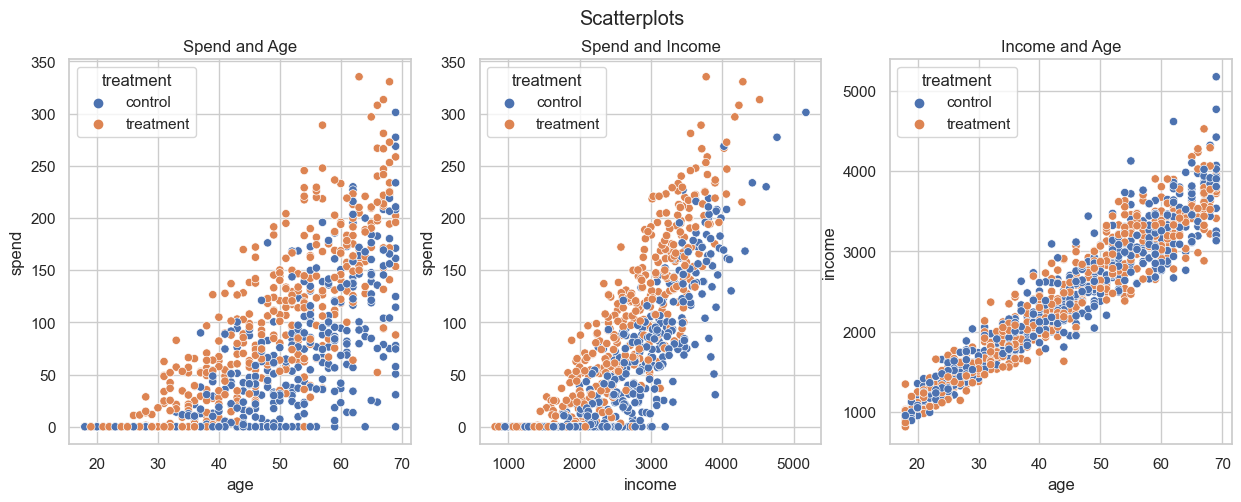

In [7]:
sample = df.sample(frac = .1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle('Scatterplots')

# Bulbasaur
sns.scatterplot(ax=axes[0], x=sample.age, y=sample.spend, hue = sample.treatment)
axes[0].set_title('Spend and Age')

# Charmander
sns.scatterplot(ax=axes[1], x=sample.income, y=sample.spend, hue = sample.treatment)
axes[1].set_title('Spend and Income')

# Squirtle
sns.scatterplot(ax=axes[2], x=sample.age, y=sample.income, hue = sample.treatment)
axes[2].set_title('Income and Age')

In [ ]:
### How is spend correlated with the categorical variables
sns.catplot(data = df, x = 'gender', y = 'spend', hue = 'treatment', kind = 'box')

In [ ]:
df['spend_quantile'] = pd.qcut(df['spend'], q = 10,duplicates='drop', labels = [4,5,6,7,8,9,10])
df.head()


In [ ]:
print(sns.__version__)

In [ ]:
g = sns.catplot(data = df, x = 'spend_quantile', y = 'spend', hue = 'treatment', kind = 'box')
g.set_yscale('log')

#fig = px.box(df, x = 'spend_quantile', y = 'spend', color = 'treatment')
#fig.show()

## Analysis of the Causal Effect of Treatment

### Difference of means

In [ ]:
df.groupby('treatment')['spend'].agg(['count','mean','median','std'])

### OLS

In [ ]:
smf.ols("spend ~ treatment", data=df).fit().summary().tables[1]

In [ ]:
smf.ols("spend ~ treatment + age + gender", data=df).fit().summary().tables[1]

### Quantile Regression

In [ ]:
smf.quantreg("spend ~ treatment", data=df).fit(q = .5).summary().tables[1]

In [ ]:
smf.quantreg("spend ~ treatment + gender + income", data=df).fit(q = .5).summary().tables[1]

### Analysis of Effect at several different quantiles

In [ ]:
def plot_quantile_te(df, formula, q, varname):
    df_results = pd.DataFrame()
    for q in np.arange(q, 1-q, q):
        qreg = smf.quantreg(formula, data=df).fit(q=q)
        temp = pd.DataFrame({'q': [q],
                             'coeff': [qreg.params[varname]], 
                             'std': [qreg.bse[varname]],
                             'ci_lower': [qreg.conf_int()[0][varname]],
                             'ci_upper': [qreg.conf_int()[1][varname]]})
        df_results = pd.concat([df_results, temp]).reset_index(drop=True)
    
    # Plot
    fig, ax = plt.subplots()
    sns.lineplot(data=df_results, x='q', y='coeff')
    ax.fill_between(data=df_results, x='q', y1='ci_lower', y2='ci_upper', alpha=0.1);
    plt.axhline(y=0, c="k", lw=2, zorder=1)
    ols_coeff = smf.ols(formula, data=df).fit().params[varname]
    plt.axhline(y=ols_coeff, ls="--", c="C1", label="OLS coefficient", zorder=1)
    plt.legend()
    plt.title("Estimated coefficient, by quantile")

In [ ]:
plot_quantile_te(df, formula = "spend ~ treatment",varname = 'treatment[T.treatment]', q = .05)

In [ ]:
smf.quantreg("spend ~ treatment + gender + income", data=df).fit(q = .5).summary()

In [ ]:
results = smf.quantreg("spend ~ treatment + gender + income", data=df).fit(q = .5)

results.params

In [ ]:
results.params['income']

In [ ]:
a = smf_results_to_df(results)
a

In [ ]:
def run_quantile_regressions(df, formula, q, varname):
    # Function runs multiple quantile regressions and returns a dataframe with the results for a selected vareter of interest
    # Arguments:
        # df: dataframe
        # formula: regression equation you wish to use, example "spend ~ treatment + gender + income"
        # q: The space between each quantile regression i.e. q=.1 would be every decile
        # varname: The variable in the regression equation whose estimated parameter you wish to return example: "income"   
    all_qr_results = pd.DataFrame()
    for q in np.arange(q, 1-q, q):
        qreg = smf.quantreg(formula, data=df).fit(q=q)
        temp = pd.DataFrame({'coefficient':varname,
                             'q': [q],
                             'coeff': [qreg.params[varname]], 
                             'std': [qreg.bse[varname]],
                             'p_value':[qreg.pvalues[varname]],
                             'ci_lower': [qreg.conf_int()[0][varname]],
                             'ci_upper': [qreg.conf_int()[1][varname]]})
        all_qr_results = pd.concat([all_qr_results, temp]).reset_index(drop=True)
    return(all_qr_results)



In [8]:
qrs = run_quantile_regressions(df, formula = "spend ~ treatment + gender + income", varname = "treatment[T.treatment]", q = .05)
qrs

NameError: name 'pd' is not defined

In [ ]:
# Plot
fig, ax = plt.subplots()
sns.lineplot(data=qrs, x='q', y='coeff')
ax.fill_between(data=qrs, x='q', y1='ci_lower', y2='ci_upper', alpha=0.1);
plt.axhline(y=0, c="k", lw=2, zorder=1)
ols_coeff = smf.ols("spend ~ treatment + gender + income", data=df).fit().params["treatment[T.treatment]"]
plt.axhline(y=ols_coeff, ls="--", c="C1", label="OLS coefficient", zorder=1)
plt.legend()
plt.title("Estimated coefficient, by quantile")